Symphony Sense:
A project which aims to recognise instruments through chords, and MFCC which is Mel-Frequency Cepstral Coefficients. It is a representation of the short-term power spectrum of a sound, widely used in speech and audio processing applications, including speech recognition and music information retrieval.

To understand how MFCC works we will go for a demo:

---
Here we are fetching an audio file from
https://theremin.music.uiowa.edu/MIS-Pitches-2012/MISViolin2012.html

which is our primary inspiration for this project

---



In [ ]:
# We first import all the necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, optimizers, regularizers

import os  # Import the OS module for file and directory handling
import csv  # Import CSV module for writing the results to a CSV file
import pandas as pd  # Import Pandas for managing data, particularly to handle dataframes and CSV files



In [ ]:
!wget "https://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Flute/Flute.nonvib.ff.D4.stereo.aif"

--2024-08-18 16:27:51--  https://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Woodwinds/Flute/Flute.nonvib.ff.D4.stereo.aif
Resolving theremin.music.uiowa.edu (theremin.music.uiowa.edu)... 128.255.102.97, 2620:0:e50:680c::4e
Connecting to theremin.music.uiowa.edu (theremin.music.uiowa.edu)|128.255.102.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 691126 (675K) [audio/x-aiff]
Saving to: ‘Flute.nonvib.ff.D4.stereo.aif’

Flute.nonvib.ff.D4. 100%[===================>] 674.93K  3.34MB/s    in 0.2s    

2024-08-18 16:27:51 (3.34 MB/s) - ‘Flute.nonvib.ff.D4.stereo.aif’ saved [691126/691126]



In [ ]:
aiff_file = 'Flute.nonvib.ff.D4.stereo.aif'
wav_file = 'Flute.nonvib.ff.D4.stereo.aif.wav'

!ffmpeg -y -i $aiff_file $wav_file

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

 The initial red area could indicate an initial loud sound or a transient, such as a sharp musical note, a clap, or a burst of speech. Towards the end we see there is a sustained low amplitude which suggests a quieter segment or background noise following the initial loud sound.

---

Now we will listen to the audio to verify this

In [ ]:
import IPython.display as ipd
ipd.Audio(wav_file)

[[-905.0967    -905.0967    -903.3824    ... -905.0967    -905.0967
  -905.0967   ]
 [   0.           0.           2.3163817 ...    0.           0.
     0.       ]
 [   0.           0.           2.002121  ...    0.           0.
     0.       ]
 ...
 [   0.           0.          -2.3681815 ...    0.           0.
     0.       ]
 [   0.           0.          -2.3622522 ...    0.           0.
     0.       ]
 [   0.           0.          -2.1465657 ...    0.           0.
     0.       ]]


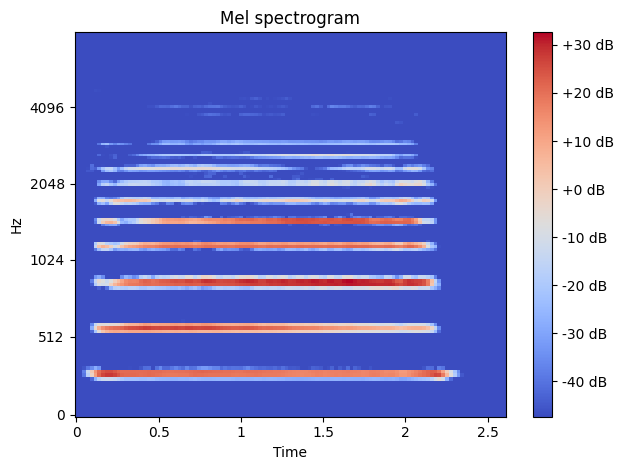

In [ ]:
# Load the audio file
y, sr = librosa.load(aiff_file)

# Compute the Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

# Convert the Mel spectrogram to decibels
S_dB = librosa.amplitude_to_db(S, ref=np.max)

# Extract the MFCCs
mfccs = librosa.feature.mfcc(S=S_dB, sr=sr, n_mfcc=13)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
print(mfccs)


**The above process was for demonstration. The audio files used in this project are obtained from various sources such as YouTube and some other platforms. There has been no intention of copyright or plagarisim, and have been used for the purpose of this project only.**

Based on this principle, we will now use some of the audio files of songs with one instrument. The model using tensor flow will be trained on that and then we will test with audio file(s) to check the type of instrument. In this we will also use the chords used in the songs to determine the instrument.

**How will we extract chords of the audio from our dataset?**



This code processes audio files from different musical instruments (like Violin, Cello, Trumpet, etc.) to detect chords (like major, minor, and noise chords) in each audio file. It does this by first creating templates for the different types of chords and then applying these templates to chroma features (which represent the energy distribution across different pitches in the audio). The code processes each audio file channel by channel, computes the likelihood of each chord over time, and uses a method called Viterbi decoding to identify the most likely sequence of chords in the audio. After detecting the chords for each audio file, it saves the results to a CSV file, which includes information about the instrument, file name, time of the chord, the detected chord, and the audio channel it was detected on. The final CSV file provides a detailed breakdown of chords detected across all processed audio files.

Lets take an example of a recording of a live concert where a musician is playing chords and a vocalist is singing. In a stereo recording, the the music from the instrument might be more prominent in the left channel, while the vocals are more prominent in the right channel. This separation creates a richer listening experience and allows for spatial differentiation between the instruments.

If we processed this recording as a mono file, the audio from both channels would be combined into a single channel. This could blur the distinction between the guitar and the vocals, making it harder to accurately detect the chords played by the guitar, especially if the vocals are dominant in certain frequency ranges.

By using stereo processing, the code can independently analyze the left and right channels. It might detect the guitar chords more clearly in the left channel while capturing different aspects of the audio, such as vocal harmonies or effects, in the right channel. This method ensures that the chord detection is more accurate and that important musical details present in one channel but not the other are not lost.

For example, in the left channel, the code might detect a "G
" chord at 30 seconds into the recording, while in the right channel at the same time, the vocals might cause a "N" (noise or no chord) detection. By processing the stereo file, the code captures this nuanced difference, leading to a richer and more detailed chord analysis.

In [ ]:
# We will first write a function to process a single audio file and detect chords
def process_audio_file(instrument, file_path):
    # Create chord templates for major, minor, and noise chords
    # These templates are used to match the chroma features to their corresponding chords.
    maj_template = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])  # Major chord template
    min_template = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])  # Minor chord template
    N_template = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) / 4  # Noise chord template (normalized)

    # Initialize the weighting matrix, which maps chroma features to chord probabilities
    weights = np.zeros((25, 12), dtype=float)

    # Define the labels corresponding to each chord (12 major, 12 minor, and 1 noise)
    labels = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'F:maj', 'F#:maj', 'G:maj',
              'G#:maj', 'A:maj', 'A#:maj', 'B:maj', 'C:min', 'C#:min', 'D:min', 'D#:min',
              'E:min', 'F:min', 'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min', 'N']

    # Fill the weights matrix by rolling the chord templates across the chroma features
    for c in range(12):
        weights[c, :] = np.roll(maj_template, c)  # Roll and assign major chord template
        weights[c + 12, :] = np.roll(min_template, c)  # Roll and assign minor chord template
    weights[-1] = N_template  # Assign the noise chord template

    # Generate a transition matrix for Viterbi decoding, favoring self-loops
    trans = librosa.sequence.transition_loop(25, 0.9)

    # Load the audio file; librosa loads it as mono by default, so specify mono=False to load in stereo/multi-channel
    y, sr = librosa.load(file_path, mono=False)

    # If the audio is mono, reshape it to be multi-channel with one channel
    if y.ndim == 1:  # Check if the audio is mono (single dimension)
        y = y[np.newaxis, :]  # Add an axis to make it multi-channel with one channel

    # List to hold detected chords for all channels in the audio
    detected_chords_all_channels = []

    # Process each channel of the audio separately
    for channel in range(y.shape[0]):
        y_channel = y[channel, :]  # Extract the audio data for the current channel
        y_channel = librosa.effects.harmonic(y_channel, margin=4)  # Enhance harmonic components

        # Compute the chroma feature (pitch class energy distribution)
        chroma = librosa.feature.chroma_cqt(y=y_channel, sr=sr)

        # Map chroma features to chord probabilities using the weights matrix
        probs = np.exp(weights.dot(chroma))  # Compute the probabilities
        probs /= probs.sum(axis=0, keepdims=True)  # Normalize the probabilities

        # Perform Viterbi decoding to find the most likely sequence of chords
        chords_vit = librosa.sequence.viterbi_discriminative(probs, trans)

        # Get the corresponding times for each detected chord
        times = librosa.times_like(chords_vit)

        # Store the detected chords along with their times
        detected_chords = [(round(time), labels[chord]) for time, chord in zip(times, chords_vit)]
        detected_chords_all_channels.append(detected_chords)

    # Combine results from all channels, ensuring unique chords per second per channel
    final_results = []
    for channel_idx, detected_chords in enumerate(detected_chords_all_channels):
        unique_chords = {}  # Dictionary to track unique chords per second
        for time, chord in detected_chords:
            if time not in unique_chords:  # Ensure each second has only one chord per channel
                unique_chords[time] = chord
                # Append the final result tuple (Instrument, Filename, Time, Chord, Channel)
                final_results.append((instrument, os.path.basename(file_path), time, chord, f"Channel {channel_idx+1}"))

    return final_results  # Return the processed results for this audio file


In [ ]:
# Initialize an empty list to collect results from processing all audio files
all_results = []

# Define paths to directories containing audio files for different instruments
paths = {
    "Violin": "/content/drive/MyDrive/audio/Violin",
    "Double Bass": "/content/drive/MyDrive/audio/Double Bass",
    "Harp": "/content/drive/MyDrive/audio/Harp",
    "Cello": "/content/drive/MyDrive/audio/Cello",
    "Trumpet": "/content/drive/MyDrive/audio/Trumpet",
    "Piccolo": "/content/drive/MyDrive/audio/Piccolo",
    "Oboe":"/content/drive/MyDrive/audio/Oboe"
}

# Loop through each instrument and its corresponding directory
for instrument, directory in paths.items():
    for filename in os.listdir(directory):  # Iterate over each file in the directory
        if filename.endswith('.wav'):  # Process only .wav files
            file_path = os.path.join(directory, filename)  # Get the full file path
            results = process_audio_file(instrument, file_path)  # Process the file
            all_results.extend(results)  # Append the results to the overall list

# Define the path to the output CSV file
csv_file_path = '/content/drive/MyDrive/chord_data_ss.csv'

# Write the results to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['Instrument', 'File', 'Time', 'Chord', 'Channel']  # Define the CSV headers
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)  # Create a DictWriter object

    writer.writeheader()  # Write the header row to the CSV
    for result in all_results:  # Iterate over the results
        writer.writerow({'Instrument': result[0], 'File': result[1], 'Time': result[2], 'Chord': result[3], 'Channel': result[4]})  # Write each row

# Print a confirmation message once the data is saved
print(f"Chord data saved to {csv_file_path}")


Chord data saved to /content/drive/MyDrive/chord_data_ss.csv


Our chords dataset is now saved here. We will have a quick glance at it


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/chord_data_ss.csv")
data = df.head()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df.to_csv("file_name.csv", sep='\t', encoding='utf-8')

print (data)

  Instrument          File  Time   Chord    Channel
0     Violin  Violin-1.wav     0   E:min  Channel 1
1     Violin  Violin-1.wav     1  F#:min  Channel 1
2     Violin  Violin-1.wav     2   A:maj  Channel 1
3     Violin  Violin-1.wav     3   D:maj  Channel 1
4     Violin  Violin-1.wav     4  F#:maj  Channel 1


Now as we can see there is a specific column named channel 1 with different chords in consecutive seconds. We have used a similar approach used in page mentioned by audiolabs *https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S2_ChordRec_Templates.html*
where they have taken an extensive approach. These templates present in the code for Major Minor and Noise, represent prototypical chroma vectors corresponding to specific musical chords. The method involves comparing chroma features extracted from audio with these precomputed templates to identify the most likely chords.



---

Now we move forward to the second part of the project, Calculating Mel-Frequency Cepstral Coefficients.

* **What is MFCC?**
* **How is it going to help us with the Orchestral Instrument detection?**





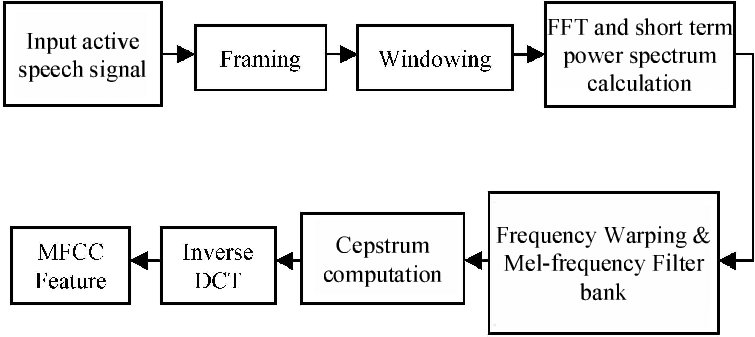


Source: https://www.researchgate.net/figure/Flow-Diagram-of-MFCC-Calculation-Algorithm-2-Algorithm-for-MFCC-calculation-l_fig2_304412686

To understand the flowchart lets tackle each part seperately.

***1) Input Signal to Framing***

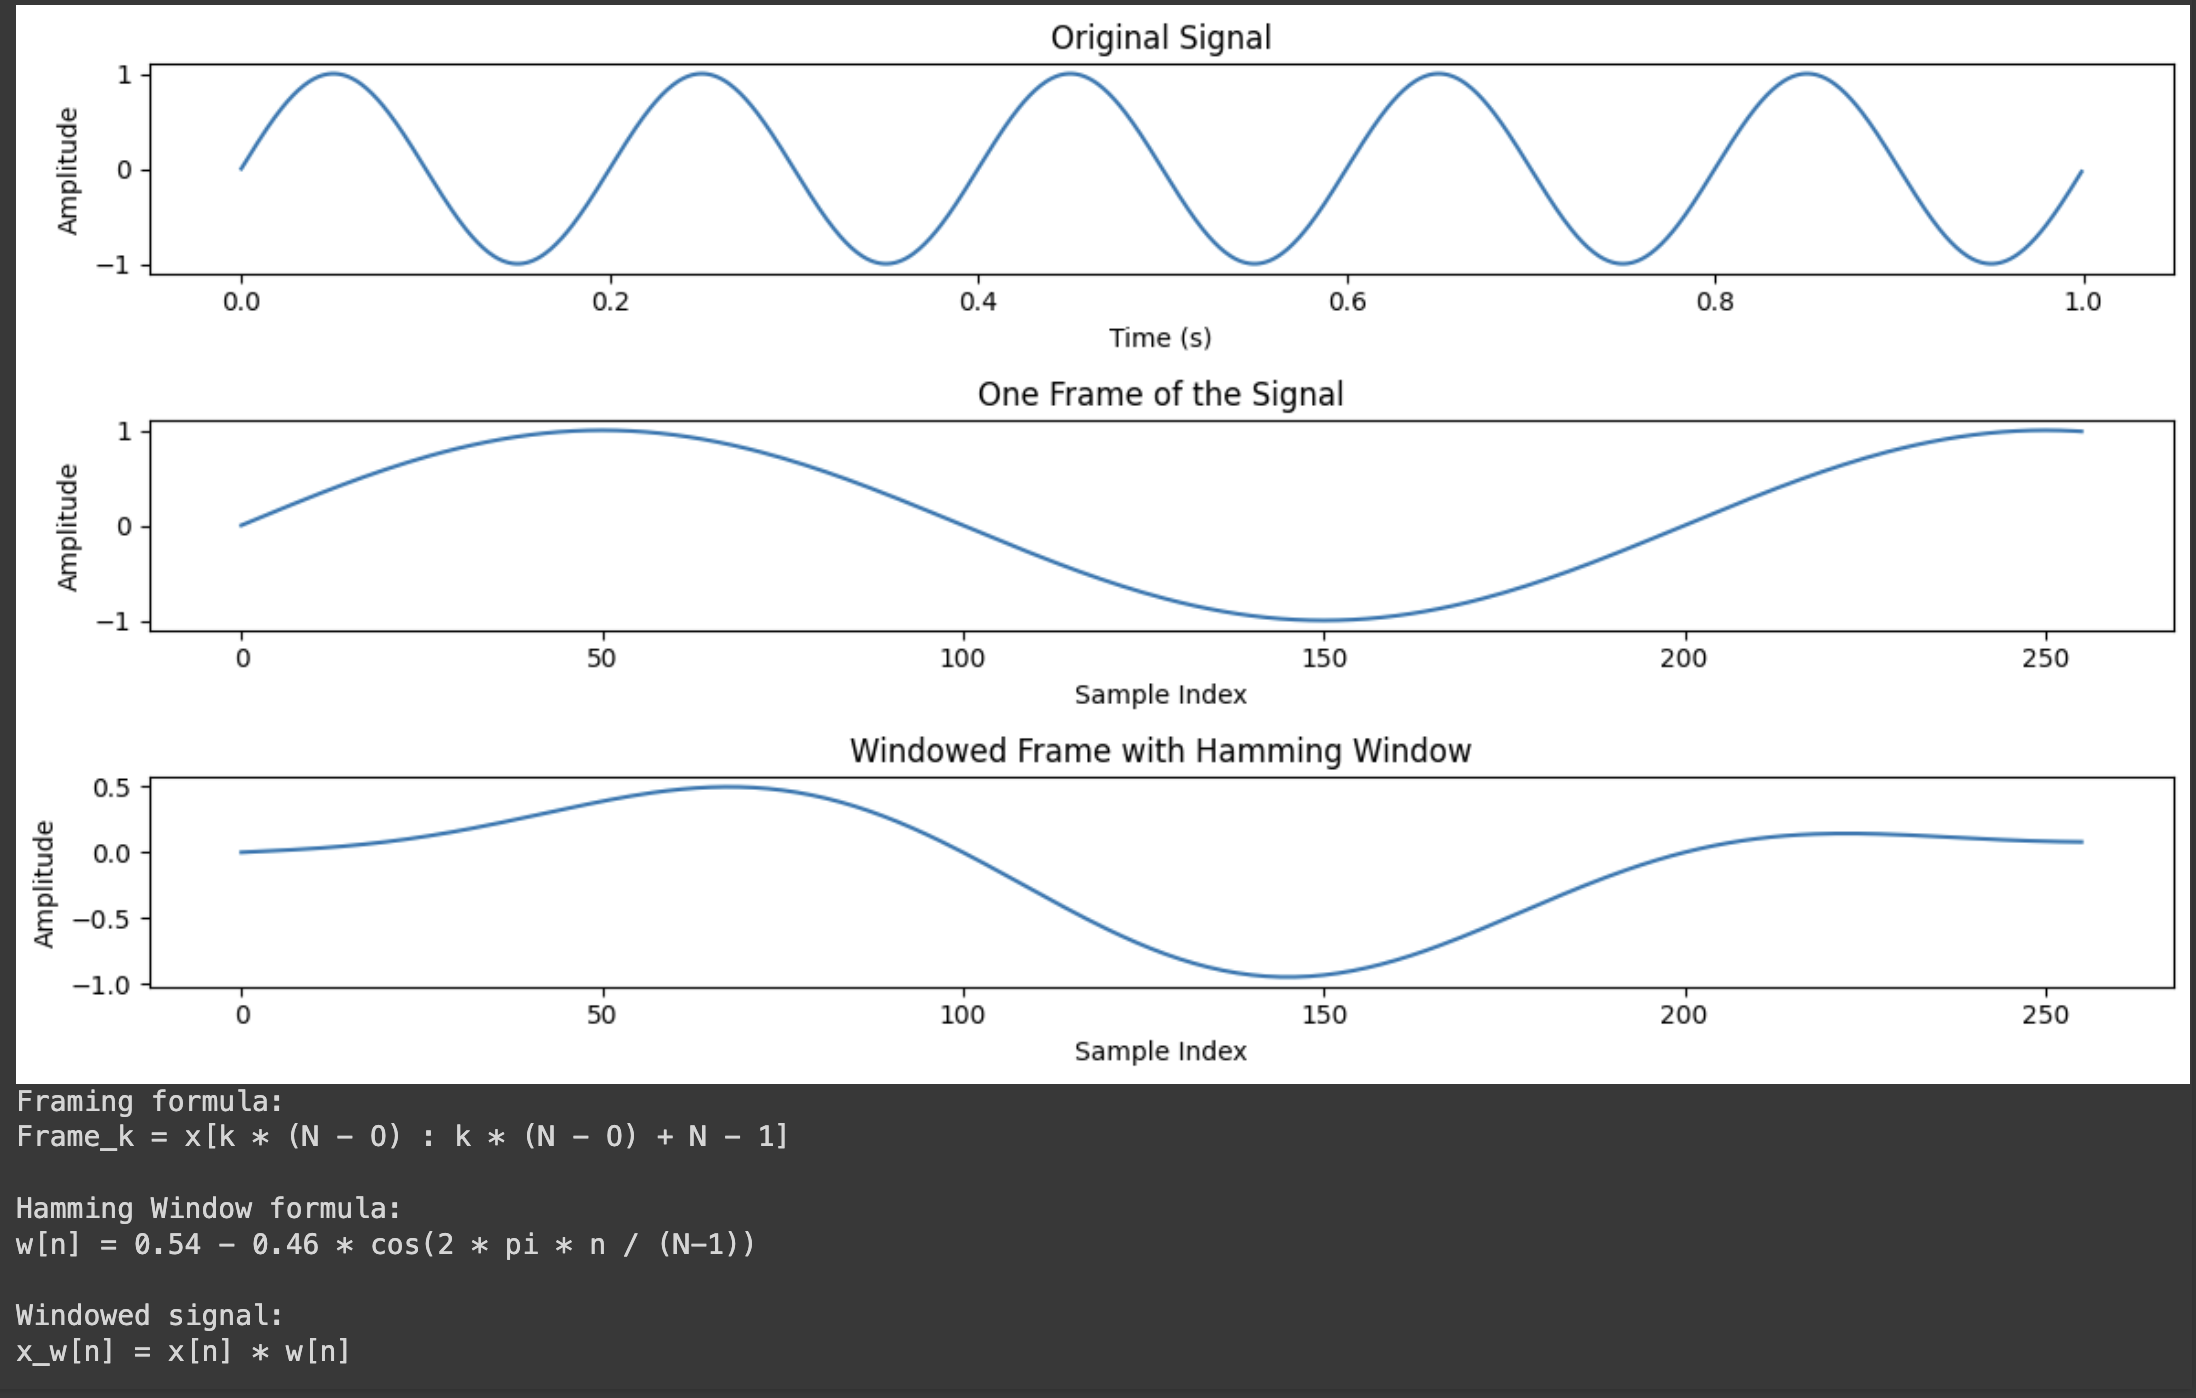

The process begins with an Input Signal which is sent for Framing which is the process of segmenting the speech samples obtained from analog to digital conversion (ADC) into a small frame with the length within the range of 20 to 40 msec. Post this, we have the process of Windowing. Windowing is applied to each frame to minimize abrupt changes or discontinuities at the beginning and end of the frame. It involves multiplying each frame by a window function, like the Hamming window, which tapers the signal's edges smoothly down to zero. This helps to reduce spectral leakage. To understand this better lets consider, having multiple threads of different colours, and it is difficult to segregate them if these are long threads. To simplify this we apply the process of Framing which will cut these threads to small ones and there is a possiblity that the threads at the ends after framing are abrupt. To avoid this, we apply windowing which is smoothing the ends. The technique used is Hamming window which applies a smoothing function to the ends.

After framing and windowing, the next step in processing the audio signal is to analyze the frequency content of each frame. This is done using the Fast Fourier Transform (FFT). The FFT converts the time-domain signal in each frame into the frequency domain, showing how much of each frequency is present in the signal. The short-term power spectrum is then calculated by taking the magnitude squared of the FFT.

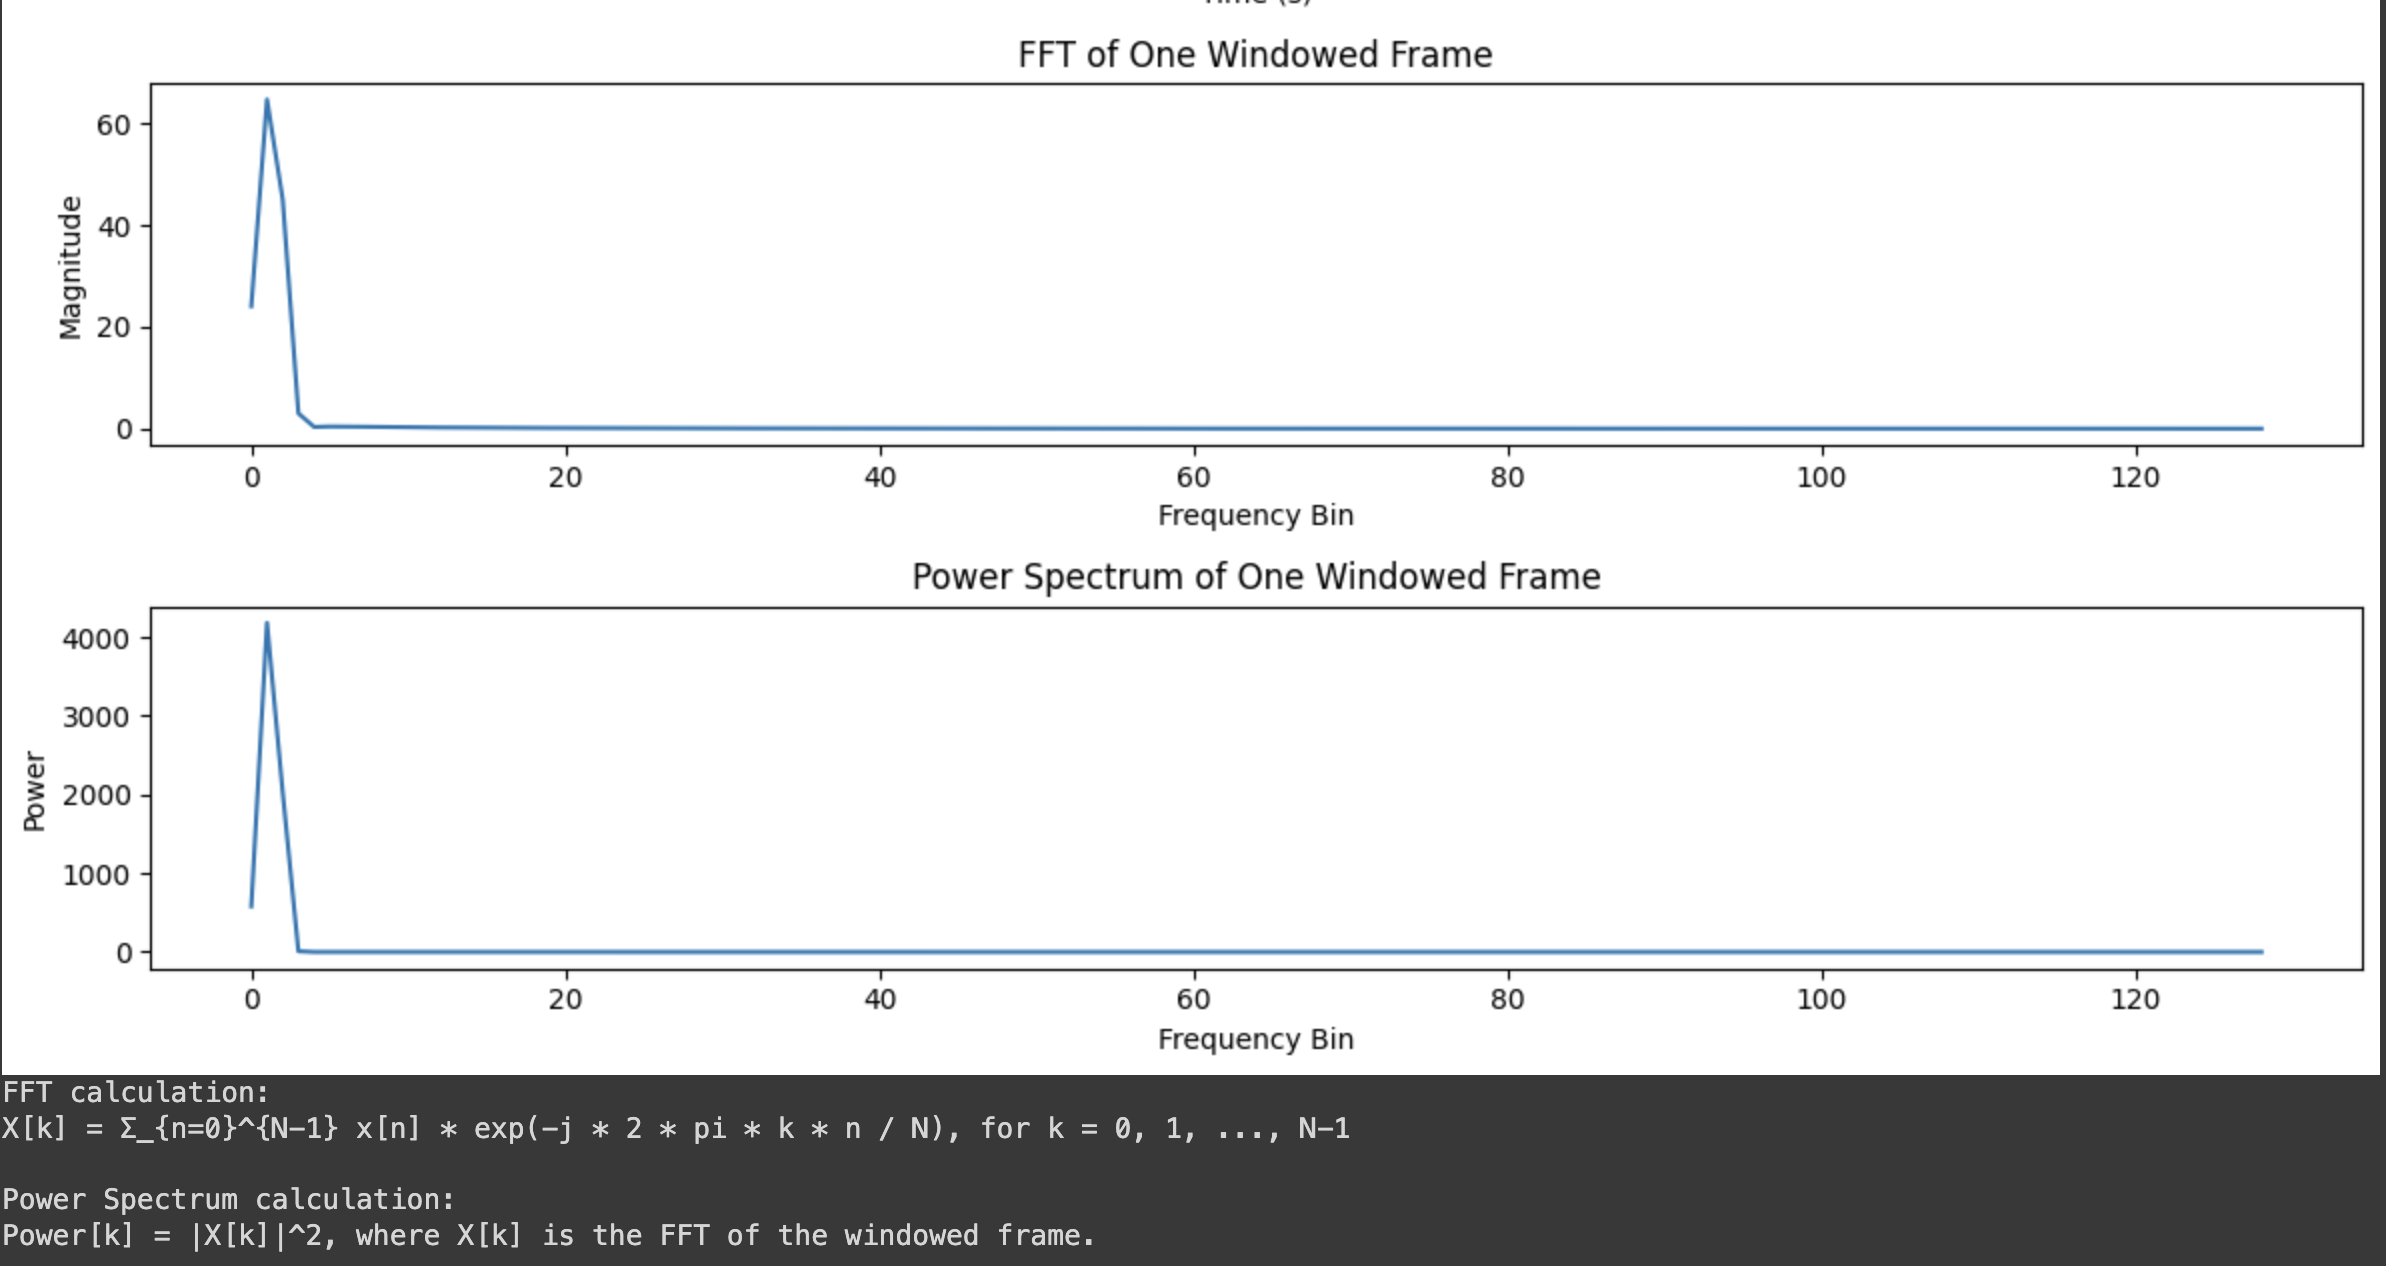

Frequency warping is the process of transforming the frequency scale to match how humans perceive sound frequencies. The human ear perceives frequency on a nonlinear scale, meaning we are more sensitive to differences in lower frequencies (e.g., 100 Hz to 200 Hz) than in higher frequencies (e.g., 5000 Hz to 5100 Hz). To model this, we use the Mel scale. Mel Filter Bank block outputs a frequency-domain auditory filter bank using the mel frequency scale. You can use a mel filter bank to decompose an audio signal into separate frequency bands in the mel frequency scale, which mimics the nonlinear human perception of sound.

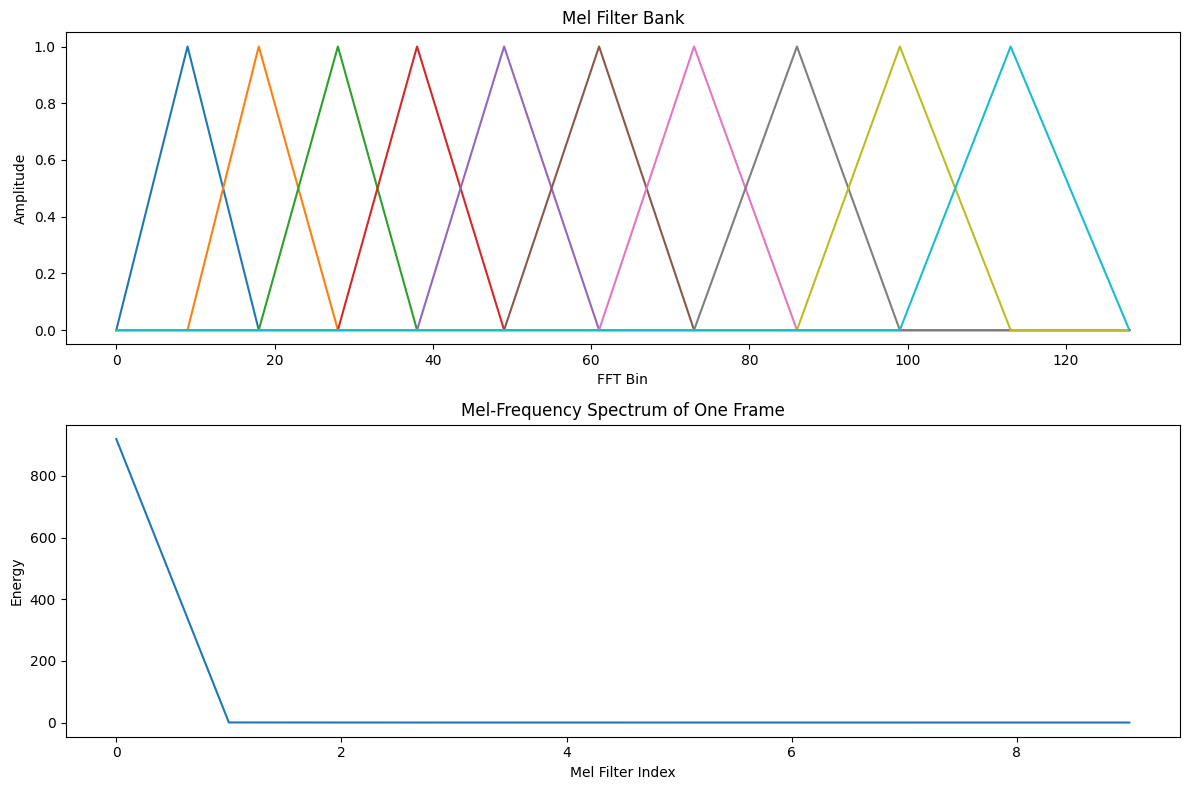

After the sound signal is passed through the Mel filter bank (which gives the Mel-frequency spectrum), the next step is to take the logarithm of the spectrum. Once we have the log Mel-frequency spectrum, then applied is the Discrete Cosine Transform (DCT) to it. This step converts the signal from the frequency domain into the cepstral domain. The DCT helps to de-correlate the spectrum coefficients, which means it separates the important features of the sound from less important ones and at the end we have MFCC which are a set of coefficients that represent the short-term power spectrum of a sound, and they are designed to reflect the way our ears perceive sounds.



---
Now that we have understood what MFCC is we will use python library librosa to find the MFCC for the audio files for which we found the chords for.


In [ ]:
# Function to extract MFCC features from an entire audio file
# The higher coefficients usually capture noise or less relevant information,
# so they are often discarded.
# In summary, 13 is a common choice because it balances capturing enough detail
# about the spectral envelope of the audio signal without retaining
# too much noise or irrelevant data.

def extract_mfcc_whole_audio(audio_path, n_mfcc=13, n_frames=50):
    # Load the audio file using Librosa, sr=None means original sampling
    # rate is preserved
    # The 50 time frames represent the number of segments of the audio signal
    # you want to analyze. This is more about how you want to capture the entire
    # duration of the audio file, ensuring consistency across different files
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the MFCCs (Mel-Frequency Cepstral Coefficients)
    # from the audio signal
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Ensure that MFCCs have a fixed number of frames (columns)
    # For different audio files these could be different so we would set that using this
    if mfccs.shape[1] > n_frames:  # If more frames than desired
        mfccs = mfccs[:, :n_frames]  # Truncate to the desired number of frames
    elif mfccs.shape[1] < n_frames:  # If fewer frames than desired
        pad_width = n_frames - mfccs.shape[1]  # Calculate the padding needed
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')  # Pad with zeros

    return mfccs  # Return the MFCCs, now with a fixed shape

# Dictionary mapping instrument names to their respective directories
paths = {
    "violin": "/content/drive/MyDrive/audio/Violin",
    "double bass": "/content/drive/MyDrive/audio/Double Bass",
    "harp": "/content/drive/MyDrive/audio/Harp",
    "cello": "/content/drive/MyDrive/audio/Cello",
    "trumpet": "/content/drive/MyDrive/audio/Trumpet",
    "piccolo": "/content/drive/MyDrive/audio/Piccolo",
    "Oboe":"/content/drive/MyDrive/audio/Oboe"

}

# Lists to store MFCC features, their corresponding labels, and any files that cause errors
all_mfcc_features = []
labels = []
error_files = []

# Process each directory of audio files, one for each instrument
for label, directory in paths.items():
    for filename in os.listdir(directory):  # Iterate over each file in the directory
        if filename.endswith('.wav'):  # Only process .wav files
            file_path = os.path.join(directory, filename)  # Full path to the audio file
            try:
                # Extract MFCC features from the audio file
                mfcc_features = extract_mfcc_whole_audio(file_path)
                print(f"Processing file {file_path}, MFCC shape: {mfcc_features.shape}")

                # Ensure the MFCCs have the expected shape before storing
                if mfcc_features.shape == (13, 50):  # Check if the shape is (13, 50)
                    all_mfcc_features.append(mfcc_features.flatten())  # Flatten and store the features
                    labels.append(label)  # Store the corresponding instrument label
                else:
                    # Raise an error if the MFCC shape is unexpected
                    raise ValueError(f"Unexpected MFCC shape {mfcc_features.shape} in file {file_path}")
            except Exception as e:
                # Catch any errors that occur during processing and log the file path
                print(f"Error processing file {file_path}: {e}")
                error_files.append(file_path)

# For later troubleshooting this was added but is not a necessary condition
# Print out any files that caused errors during processing
if error_files:
    print("The following files caused errors:")
    for error_file in error_files:
        print(error_file)

Processing file /content/drive/MyDrive/audio/Violin/Violin-1.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-2.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-3.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-4.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-5.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-6.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-7.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-8.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-9.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-10.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/audio/Violin/Violin-11.wav, MFCC shape: (13, 50)
Processing file /content/drive/MyDrive/au

In [ ]:
# Convert the lists of features and labels into Pandas DataFrames
df_features = pd.DataFrame(all_mfcc_features)  # Features DataFrame
df_labels = pd.DataFrame(labels, columns=['label'])  # Labels DataFrame

# Save the features and labels to CSV files
df_features.to_csv('/content/drive/MyDrive/mfcc_features_ss.csv', index=False)  # Save features
df_labels.to_csv('/content/drive/MyDrive/labels_ss.csv', index=False)  # Save labels

# Print confirmation that the data has been saved
print("MFCC features and labels saved to CSV files.")

MFCC features and labels saved to CSV files.


# **This was Data Processing**

Before we proceed with training and testing the model, we will learn a bit about ***Delta MFCC***
Delta MFCCs help in understanding these transitions, making them useful in tasks like music genre classification or instrument recognition.
Delta MFCCs capture how these characteristics change over time.

Static MFCCs: First, the MFCCs are computed for each frame of the audio signal.
First-Order Delta (Δ) Coefficients: The first-order delta coefficients represent the rate of change of the MFCCs between adjacent frames. Mathematically, this is often computed as a linear regression over a certain number of frames around the current frame.

Second-Order Delta-Delta (ΔΔ) Coefficients:
First-Order Delta (Δ) Coefficients:
Capture the Rate of Change: First-order deltas capture how the MFCC values are changing over time. In the context of musical instrument detection, this can help identify transitions between notes or changes in timbre that are characteristic of certain instruments.

Second-Order Delta (ΔΔ) Coefficients:
Capture Acceleration: Second-order deltas capture the rate of change of the first-order deltas (essentially, the acceleration of the MFCC values).

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, optimizers, regularizers

# Setting the seed for reproducibility
# -------------------------------------
# To ensure our results are consistent across different runs,
# we set seeds for random number generators used by various libraries.
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.config.experimental.enable_op_determinism()  # Ensures deterministic behavior for TensorFlow operations


In [ ]:
# Function to calculate delta MFCC features Here we will use 1 and in the next chunk (at the end will use 2 to compare the results)
# -----------------------------------------
# MFCCs (Mel-frequency cepstral coefficients) are a common feature used in audio processing.
# Delta MFCCs capture the temporal changes in the MFCCs, which can be useful for tasks like
# speech recognition or music classification.
def compute_delta_mfcc(mfcc_features):
    delta_mfcc_features = librosa.feature.delta(mfcc_features, order=1)
    return delta_mfcc_features

In [ ]:
# Function to load and prepare data for training
# ----------------------------------------------
# This function loads MFCC features, labels, and chord data from CSV files,
# processes them, and splits the data into training, validation, and test sets.
def load_and_prepare_data(mfcc_file, label_file, chord_file, batch_size=100):
    # Load MFCC features from the provided CSV file
    mfcc_features = pd.read_csv(mfcc_file).values.astype(np.float32)

    # Load labels from the label CSV file
    labels = pd.read_csv(label_file)['label'].values.flatten()

    # Load chord data from the chord CSV file
    chord_data = pd.read_csv(chord_file)

    # Ensure only the 'Chord' column is used in the chord data
    chord_data = chord_data[['Chord']]

    # One-hot encode the 'Chord' column to convert categorical data into numerical format
    chord_data = pd.get_dummies(chord_data['Chord']).values.astype(np.float32)

    # Compute delta MFCC features and concatenate them with the original MFCC features
    delta_mfcc_features = compute_delta_mfcc(mfcc_features.T).T
    mfcc_features = np.hstack((mfcc_features, delta_mfcc_features))

    # Standardize the concatenated features to have zero mean and unit variance
    mfcc_mean = mfcc_features.mean(axis=0)
    mfcc_std = mfcc_features.std(axis=0)
    mfcc_features = (mfcc_features - mfcc_mean) / mfcc_std

    # Encode the labels as integers
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels).astype(np.int32)

    # Ensure all data arrays have the same number of rows (samples)
    num_rows = min(len(mfcc_features), len(labels), len(chord_data))
    mfcc_features = mfcc_features[:num_rows]
    labels = labels[:num_rows]
    chord_data = chord_data[:num_rows]

    # Shuffle the data to randomize the order of samples
    indices = np.arange(num_rows)
    np.random.shuffle(indices)
    mfcc_features = mfcc_features[indices]
    chord_data = chord_data[indices]
    labels = labels[indices]

    # Split the data into training, validation, and test sets
    train_size = int(0.6 * num_rows)  # 60% training data
    val_size = int(0.8 * num_rows)    # 20% validation data, leaving 20% for test data

    X_train_mfcc, X_val_mfcc, X_test_mfcc = np.split(mfcc_features, [train_size, val_size])
    X_train_chord, X_val_chord, X_test_chord = np.split(chord_data, [train_size, val_size])
    y_train, y_val, y_test = np.split(labels, [train_size, val_size])

    # Return data generators for training, along with validation and test data
    return (
        data_generator(X_train_mfcc, X_train_chord, y_train, batch_size),
        (X_val_mfcc, X_val_chord, y_val),
        (X_test_mfcc, X_test_chord, y_test),
        {'mean': mfcc_mean, 'std': mfcc_std},  # Return mean and std for possible future use
        label_encoder  # Return the label encoder to convert labels back to their original form later
    )


In [ ]:
# Data generator for training
# ---------------------------
# This generator yields batches of data for training the model.
# It helps in feeding data to the model in chunks, which is useful for handling large datasets
# and for optimizing training speed and memory usage.
def data_generator(mfcc_data, chord_data, labels, batch_size=100):
    num_samples = len(mfcc_data)
    indices = np.arange(num_samples)

    while True:
        np.random.shuffle(indices)  # Shuffle indices to ensure batches are different each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            yield (
                (mfcc_data[batch_indices], chord_data[batch_indices]),  # Yield a batch of MFCC and chord data
                labels[batch_indices]  # Yield corresponding labels
            )


In [ ]:
# Build the neural network model
# ------------------------------
# This function creates a multi-input neural network model using Keras.
# The model takes both MFCC features and chord data as input and produces a classification output.
def build_audio_classification_model(input_shape_mfcc, input_shape_chord, num_classes, dropout_rate=0.5, l2_reg=0.002):  # Slightly increased L2 regularization
    # Define input layer for MFCC features
    mfcc_input = layers.Input(shape=(input_shape_mfcc,))

    # First dense layer for MFCC branch with L2 regularization
    mfcc_branch = layers.Dense(320, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(mfcc_input)
    mfcc_branch = layers.Dropout(dropout_rate)(mfcc_branch)  # Add Dropout

    # Define input layer for chord data
    chord_input = layers.Input(shape=(input_shape_chord,))

    # First dense layer for chord branch with L2 regularization
    chord_branch = layers.Dense(320, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(chord_input)
    chord_branch = layers.Dropout(dropout_rate)(chord_branch)  # Add Dropout

    # Combine MFCC and chord branches by concatenating them
    combined = layers.Concatenate()([mfcc_branch, chord_branch])

    # Additional dense layers for the combined branch with L2 regularization and dropout
    combined = layers.Dense(160, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    combined = layers.Dropout(dropout_rate)(combined)  # Add Dropout
    combined = layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    combined = layers.Dropout(dropout_rate)(combined)  # Add Dropout

    # Output layer with softmax activation for multi-class classification
    output = layers.Dense(num_classes, activation='softmax')(combined)

    # Create and return the model
    model = models.Model(inputs=[mfcc_input, chord_input], outputs=output)
    return model


In [ ]:
# Function to plot confusion matrix
# ---------------------------------
# The confusion matrix helps visualize the performance of the model by showing
# how many times each class was predicted correctly or incorrectly.
def plot_confusion(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Function to evaluate the model on test data
# -------------------------------------------
# This function uses the trained model to predict the classes of the test set,
# and then evaluates the performance using standard classification metrics.
def evaluate_on_test(model, X_test_mfcc, X_test_chord, y_test, label_encoder):
    # Predict class probabilities and convert to predicted class indices
    y_pred = model.predict([X_test_mfcc, X_test_chord]).argmax(axis=1)

    # Convert numerical labels back to their original form
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Print detailed classification report (precision, recall, f1-score, etc.)
    print(classification_report(y_test_labels, y_pred_labels))

    # Plot the confusion matrix
    plot_confusion(y_test_labels, y_pred_labels, label_encoder.classes_)


In [ ]:
# Main function to train and evaluate the model
# ---------------------------------------------
# This is the core function that orchestrates loading data, training the model,
# and evaluating its performance.
def train_and_evaluate(args):
    # Load and prepare data using the helper function
    train_gen, val_data, test_data, stats, label_encoder = load_and_prepare_data(
        args.mfcc_file, args.label_file, args.chord_file, args.batch_size)

    # Determine the shape of the input data for MFCC and chord branches
    input_shape_mfcc = val_data[0].shape[1]
    input_shape_chord = val_data[1].shape[1]

    # Determine the number of output classes (i.e., number of unique labels)
    num_classes = len(label_encoder.classes_)

    # Build the model using the helper function
    model = build_model_from_image(input_shape_mfcc, input_shape_chord, num_classes)

    # Compile the model with an optimizer, loss function, and metrics
    model.compile(optimizer=optimizers.Adam(learning_rate=args.learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Create a TensorFlow dataset from the training data generator
    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_gen,
        output_signature=(
            (tf.TensorSpec(shape=(None, input_shape_mfcc), dtype=tf.float32),
             tf.TensorSpec(shape=(None, input_shape_chord), dtype=tf.float32)),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )

    # Train the model using the training dataset and validate on the validation data
    model.fit(train_dataset,
              steps_per_epoch=3000,  # Number of steps (batches) per epoch
              epochs=50,  # Number of epochs to train the model
              validation_data=([val_data[0], val_data[1]], val_data[2]),
              verbose=1)

    # Evaluate the model's performance on the validation set
    val_loss, val_accuracy = model.evaluate([val_data[0], val_data[1]], val_data[2])
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Save the trained model to a file for future use
    model.save('test_final_1.h5')

    # Test the model on unseen test data and evaluate its performance
    evaluate_on_test(model, *test_data, label_encoder)


Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9676 - loss: 1.0661 - val_accuracy: 0.8000 - val_loss: 0.7114
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9963 - loss: 0.1905 - val_accuracy: 0.6667 - val_loss: 2.8097
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9963 - loss: 0.1392 - val_accuracy: 0.7333 - val_loss: 2.0981
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9968 - loss: 0.1145 - val_accuracy: 0.6000 - val_loss: 5.7805
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9943 - loss: 0.1607 - val_accuracy: 0.7333 - val_loss: 4.1001
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9974 - loss: 0.1013 - val_accuracy: 0.6667 - val_loss: 4.2724
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9941 - loss: 0.1446 - val_accuracy: 0.6000 - val_loss: 3.3090
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9970 -

Validation Loss: 15.9108, Validation Accuracy: 0.4000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
              precision    recall  f1-score   support

        Oboe       1.00      1.00      1.00         2
       cello       0.50      0.50      0.50         2
 double bass       0.40      1.00      0.57         2
        harp       0.50      0.33      0.40         3
     piccolo       1.00      0.50      0.67         4
     trumpet       1.00      1.00      1.00         1
      violin       1.00      1.00      1.00         2

    accuracy                           0.69        16
   macro avg       0.77      0.76      0.73        16
weighted avg       0.77      0.69      0.69        16



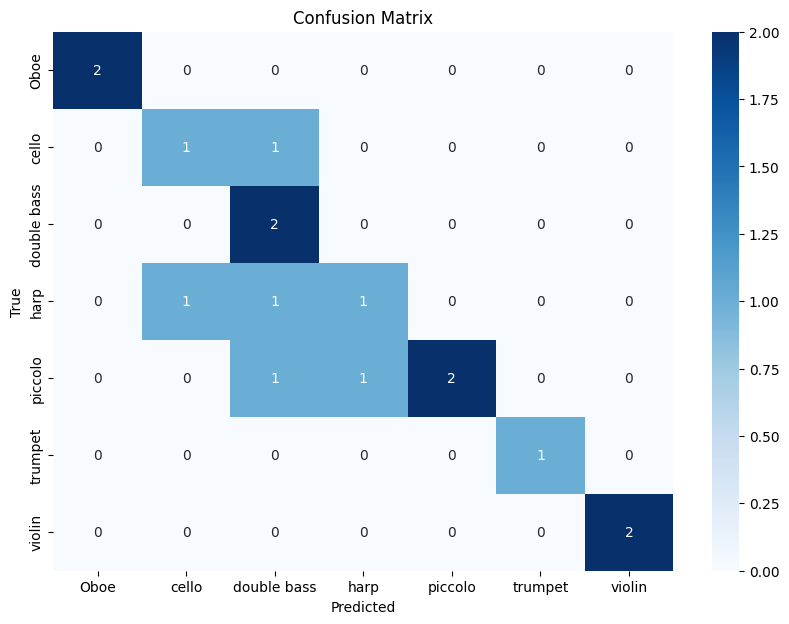

In [ ]:
# Entry point of the script
# -------------------------
# This is where the script starts execution. It sets up argument parsing
# and calls the train_and_evaluate function.
if __name__ == '__main__':
    # Define a simple class to hold arguments for the script
    class Args:
        mfcc_file = '/content/drive/MyDrive/mfcc_features_ss.csv'
        label_file = '/content/drive/MyDrive/labels_ss.csv'
        chord_file = '/content/drive/MyDrive/chord_data_ss.csv'
        max_iterations = 15000
        batch_size = 50
        learning_rate = 0.005

    # Instantiate the Args class and pass it to the train_and_evaluate function
    args = Args()
    train_and_evaluate(args)


The model performs well in depicting Oboe, mildly performs well in detecting Cello, and can be seen confusing cello with double bass as there are instances and certain notes where it could sound similar. Double Bass on whole seem dominating and is predicted correctly but is confused with Harp. Piccolo has been correctly identified 2/4 times with trumpet once and Violin twice.

Optional:
Lastly we will run this model using Second-Order Delta (ΔΔ) Coefficients

In [ ]:

# Setting the seed for reproducibility
# -------------------------------------
# To ensure our results are consistent across different runs,
# we set seeds for random number generators used by various libraries.
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.config.experimental.enable_op_determinism()  # Ensures deterministic behavior for TensorFlow operations

# Function to calculate delta MFCC features
# -----------------------------------------
# MFCCs (Mel-frequency cepstral coefficients) are a common feature used in audio processing.
# Delta MFCCs capture the temporal changes in the MFCCs, which can be useful for tasks like
# speech recognition or music classification.
def compute_delta_mfcc(mfcc_features):
    delta_mfcc_features = librosa.feature.delta(mfcc_features, order=2)
    return delta_mfcc_features

# Function to load and prepare data for training
# ----------------------------------------------
# This function loads MFCC features, labels, and chord data from CSV files,
# processes them, and splits the data into training, validation, and test sets.
def load_and_prepare_data(mfcc_file, label_file, chord_file, batch_size=100):
    # Load MFCC features from the provided CSV file
    mfcc_features = pd.read_csv(mfcc_file).values.astype(np.float32)

    # Load labels from the label CSV file
    labels = pd.read_csv(label_file)['label'].values.flatten()

    # Load chord data from the chord CSV file
    chord_data = pd.read_csv(chord_file)

    # Ensure only the 'Chord' column is used in the chord data
    chord_data = chord_data[['Chord']]

    # One-hot encode the 'Chord' column to convert categorical data into numerical format
    chord_data = pd.get_dummies(chord_data['Chord']).values.astype(np.float32)

    # Compute delta MFCC features and concatenate them with the original MFCC features
    delta_mfcc_features = compute_delta_mfcc(mfcc_features.T).T
    mfcc_features = np.hstack((mfcc_features, delta_mfcc_features))

    # Standardize the concatenated features to have zero mean and unit variance
    mfcc_mean = mfcc_features.mean(axis=0)
    mfcc_std = mfcc_features.std(axis=0)
    mfcc_features = (mfcc_features - mfcc_mean) / mfcc_std

    # Encode the labels as integers
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels).astype(np.int32)

    # Ensure all data arrays have the same number of rows (samples)
    num_rows = min(len(mfcc_features), len(labels), len(chord_data))
    mfcc_features = mfcc_features[:num_rows]
    labels = labels[:num_rows]
    chord_data = chord_data[:num_rows]

    # Shuffle the data to randomize the order of samples
    indices = np.arange(num_rows)
    np.random.shuffle(indices)
    mfcc_features = mfcc_features[indices]
    chord_data = chord_data[indices]
    labels = labels[indices]

    # Split the data into training, validation, and test sets
    train_size = int(0.6 * num_rows)  # 60% training data
    val_size = int(0.8 * num_rows)    # 20% validation data, leaving 20% for test data

    X_train_mfcc, X_val_mfcc, X_test_mfcc = np.split(mfcc_features, [train_size, val_size])
    X_train_chord, X_val_chord, X_test_chord = np.split(chord_data, [train_size, val_size])
    y_train, y_val, y_test = np.split(labels, [train_size, val_size])

    # Return data generators for training, along with validation and test data
    return (
        data_generator(X_train_mfcc, X_train_chord, y_train, batch_size),
        (X_val_mfcc, X_val_chord, y_val),
        (X_test_mfcc, X_test_chord, y_test),
        {'mean': mfcc_mean, 'std': mfcc_std},  # Return mean and std for possible future use
        label_encoder  # Return the label encoder to convert labels back to their original form later
    )

# Data generator for training
# ---------------------------
# This generator yields batches of data for training the model.
# It helps in feeding data to the model in chunks, which is useful for handling large datasets
# and for optimizing training speed and memory usage.
def data_generator(mfcc_data, chord_data, labels, batch_size=100):
    num_samples = len(mfcc_data)
    indices = np.arange(num_samples)

    while True:
        np.random.shuffle(indices)  # Shuffle indices to ensure batches are different each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            yield (
                (mfcc_data[batch_indices], chord_data[batch_indices]),  # Yield a batch of MFCC and chord data
                labels[batch_indices]  # Yield corresponding labels
            )

# Build the neural network model
# ------------------------------
# This function creates a multi-input neural network model using Keras.
# The model takes both MFCC features and chord data as input and produces a classification output.
def build_audio_classification_model(input_shape_mfcc, input_shape_chord, num_classes, dropout_rate=0.5, l2_reg=0.002):  # Slightly increased L2 regularization
    # Define input layer for MFCC features
    mfcc_input = layers.Input(shape=(input_shape_mfcc,))

    # First dense layer for MFCC branch with L2 regularization
    mfcc_branch = layers.Dense(320, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(mfcc_input)
    mfcc_branch = layers.Dropout(dropout_rate)(mfcc_branch)  # Add Dropout

    # Define input layer for chord data
    chord_input = layers.Input(shape=(input_shape_chord,))

    # First dense layer for chord branch with L2 regularization
    chord_branch = layers.Dense(320, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(chord_input)
    chord_branch = layers.Dropout(dropout_rate)(chord_branch)  # Add Dropout

    # Combine MFCC and chord branches by concatenating them
    combined = layers.Concatenate()([mfcc_branch, chord_branch])

    # Additional dense layers for the combined branch with L2 regularization and dropout
    combined = layers.Dense(160, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    combined = layers.Dropout(dropout_rate)(combined)  # Add Dropout
    combined = layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(combined)
    combined = layers.Dropout(dropout_rate)(combined)  # Add Dropout

    # Output layer with softmax activation for multi-class classification
    output = layers.Dense(num_classes, activation='softmax')(combined)

    # Create and return the model
    model = models.Model(inputs=[mfcc_input, chord_input], outputs=output)
    return model

# Function to plot confusion matrix
# ---------------------------------
# The confusion matrix helps visualize the performance of the model by showing
# how many times each class was predicted correctly or incorrectly.
def plot_confusion(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to evaluate the model on test data
# -------------------------------------------
# This function uses the trained model to predict the classes of the test set,
# and then evaluates the performance using standard classification metrics.
def evaluate_on_test(model, X_test_mfcc, X_test_chord, y_test, label_encoder):
    # Predict class probabilities and convert to predicted class indices
    y_pred = model.predict([X_test_mfcc, X_test_chord]).argmax(axis=1)

    # Convert numerical labels back to their original form
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Print detailed classification report (precision, recall, f1-score, etc.)
    print(classification_report(y_test_labels, y_pred_labels))

    # Plot the confusion matrix
    plot_confusion(y_test_labels, y_pred_labels, label_encoder.classes_)

# Main function to train and evaluate the model
# ---------------------------------------------
# This is the core function that orchestrates loading data, training the model,
# and evaluating its performance.
def train_and_evaluate(args):
    # Load and prepare data using the helper function
    train_gen, val_data, test_data, stats, label_encoder = load_and_prepare_data(
        args.mfcc_file, args.label_file, args.chord_file, args.batch_size)

    # Determine the shape of the input data for MFCC and chord branches
    input_shape_mfcc = val_data[0].shape[1]
    input_shape_chord = val_data[1].shape[1]

    # Determine the number of output classes (i.e., number of unique labels)
    num_classes = len(label_encoder.classes_)

    # Build the model using the helper function
    model = build_audio_classification_model(input_shape_mfcc, input_shape_chord, num_classes)

    # Compile the model with an optimizer, loss function, and metrics
    model.compile(optimizer=optimizers.Adam(learning_rate=args.learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Create a TensorFlow dataset from the training data generator
    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_gen,
        output_signature=(
            (tf.TensorSpec(shape=(None, input_shape_mfcc), dtype=tf.float32),
             tf.TensorSpec(shape=(None, input_shape_chord), dtype=tf.float32)),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )

    # Train the model using the training dataset and validate on the validation data
    model.fit(train_dataset,
              steps_per_epoch=3000,  # Number of steps (batches) per epoch
              epochs=50,  # Number of epochs to train the model
              validation_data=([val_data[0], val_data[1]], val_data[2]),
              verbose=1)

    # Evaluate the model's performance on the validation set
    val_loss, val_accuracy = model.evaluate([val_data[0], val_data[1]], val_data[2])
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Save the trained model to a file for future use
    model.save('test_final_1.h5')

    # Test the model on unseen test data and evaluate its performance
    evaluate_on_test(model, *test_data, label_encoder)

# Entry point of the script
# -------------------------
# This is where the script starts execution. It sets up argument parsing
# and calls the train_and_evaluate function.
if __name__ == '__main__':
    # Define a simple class to hold arguments for the script
    class Args:
        mfcc_file = '/content/drive/MyDrive/mfcc_features_ss.csv'
        label_file = '/content/drive/MyDrive/labels_ss.csv'
        chord_file = '/content/drive/MyDrive/chord_data_ss.csv'
        max_iterations = 15000
        batch_size = 50
        learning_rate = 0.005

    # Instantiate the Args class and pass it to the train_and_evaluate function
    args = Args()
    train_and_evaluate(args)


Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.9189 - loss: 1.4925 - val_accuracy: 0.4000 - val_loss: 7.8996
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9515 - loss: 1.2496 - val_accuracy: 0.4000 - val_loss: 6.6624
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9553 - loss: 1.1614 - val_accuracy: 0.5333 - val_loss: 5.0409
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9562 - loss: 1.0090 - val_accuracy: 0.4000 - val_loss: 6.4114
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9599 - loss: 0.9074 - val_accuracy: 0.4667 - val_loss: 5.7022
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9556 - loss: 0.8687 - val_accuracy: 0.4000 - val_loss: 6.1586
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9579 - loss: 0.7547 - val_accuracy: 0.4000 - val_loss: 7.2471
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9609 -

First-order delta coefficients capture the rate of change of MFCCs, which is often crucial for tasks like speech or instrument recognition. Second-order delta coefficients, on the other hand, capture the acceleration of these changes, which might not be as relevant or necessary for the specific classification task at hand.

We have receieved the following from the test data with order = 1
        

```

      Instrument  precision    recall  f1-score   support

        Oboe       1.00      1.00      1.00         2
       cello       0.50      0.50      0.50         2
 double bass       0.40      1.00      0.57         2
        harp       0.50      0.33      0.40         3
     piccolo       1.00      0.50      0.67         4
     trumpet       1.00      1.00      1.00         1
      violin       1.00      1.00      1.00         2
      
  ```



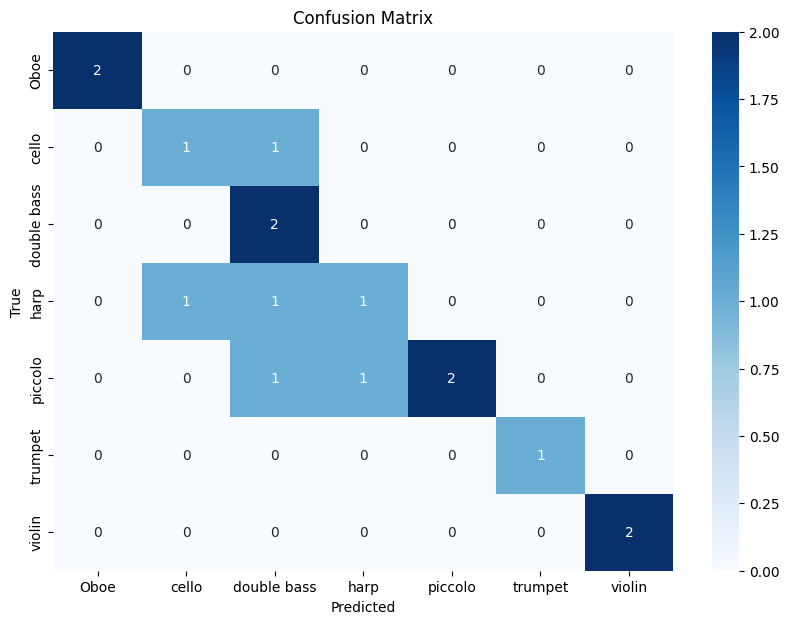